# Analysis of King County bike-related citation records

##### Ethan C. Campbell, for Central Seattle Greenways / Helmet Law Working Group

For questions, contact me at ethanchenbell@gmail.com.

#### Import packages and set file system

In [697]:
%matplotlib inline
from numpy import *
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth',50)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300     # turn on for higher-quality figure export
from datetime import datetime, timedelta
from pytz import timezone
import glob
import platform
import warnings
import sys
import progressbar
import textwrap
import censusdata

from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# choose root directory for data files
if platform.system() == 'Darwin':
    data_dir = '/Users/Ethan/Documents/Finances and records/2020-06-30 - Helmet Law Working Group/Data/'
    results_dir = '/Users/Ethan/Documents/Finances and records/2020-06-30 - Helmet Law Working Group/Figures/'
elif platform.system() == 'Linux':
    data_dir = '/dat1/ethancc/CSG/'
    results_dir = data_dir
    
# set directory paths
current_results_dir = results_dir + '2021-10-13 - King County helmet citation statistics/'

#### Load Washington Office of Financial Management (OFM) population estimates for April 2021

Data source: [WA OFM](https://ofm.wa.gov/washington-data-research/population-demographics/population-estimates/april-1-official-population-estimates) (see "April 1, 2021 population of cities, towns, and counties used for the allocation of selected state revenues").

In [121]:
ofm = pd.read_excel(data_dir + '2021-04-01 - Washington Office of Financial Management (OFM) population estimates for April 2021.xlsx',
                    sheet_name='King County',index_col=1)

#### Load compiled bike citation records

Note: file created previously in Jupyter notebook [***csg_compile_king_county_bike_citations.ipynb***](https://github.com/ethan-campbell/Miscellaneous/blob/master/csg_compile_king_county_bike_citations.ipynb), which is available on my GitHub.

In [39]:
kc_citations = pd.read_excel(data_dir + '2021-10-12 - compiled King County bike citation records.xlsx').drop(columns=['Unnamed: 0'])
kc_citations.head(3)

,Court Name,Case Number,Case Key (KCDC) or Token (MCs),Case Type,Case File Date,Law Enforcement Agency,Violation Date,Law Code,Law Description,Disposition,Disposition Date,Defendant Gender,Defendant Race,Defendant Ethnicity,Officer Badge Number,AR Ordered Amount,AR Adjustment Amount,AR Paid Amount,AR Due Amount,Originating Query,City,Violation Datetime,Officer First Name,Officer Middle Name,Officer Last Name
0,Black Diamond Municipal Court,2Z0597503,875AEBBFB026042B,Infraction Traffic,2012-09-08,Black Diamond Police Department,2012-09-07,RCW 46.61.755,Violating Laws While Riding Bicycle,Committed,2012-09-26,Male,White,Unknown,1521.0,155.0,0.0,0.0,155.0,All bike violations (requested KCHC 9.10.010 a...,Black Diamond,NaT,Scott,J,Oak
1,Black Diamond Municipal Court,BD0026522,FCEE4348BC248022,Infraction Non-Traffic,2007-08-14,Black Diamond Police Department,2007-08-13,Black Diamond Municipal Code 8.28.040,No Bicycles on Skate Park,Committed,2007-09-20,Male,White,Unknown,78693.0,75.0,-75.0,0.0,0.0,All bike violations (requested KCHC 9.10.010 a...,Black Diamond,NaT,Timothy,NaN,Macdonald
2,Black Diamond Municipal Court,BD0029627,613305D233608025,Infraction Traffic,2009-06-22,Black Diamond Police Department,2009-06-19,RCW 46.61.780,Bicycle Defective Equipment,Committed,2009-08-07,Male,White,Unknown,49330.0,155.0,0.0,155.0,0.0,All bike violations (requested KCHC 9.10.010 a...,Black Diamond,NaT,Edward,NaN,Volpone


#### Load census demographic data

Using US Census Bureau 2015-2019 ACS 5-year estimates, accessed via Python package [CensusData](https://pypi.org/project/CensusData/). Documentation here: https://jtleider.github.io/censusdata/. For an example of a DP05 table for Seattle, see [here](https://data.census.gov/cedsci/table?q=Seattle%20city,%20Washington&g=1600000US5363000&hidePreview=true&tid=ACSDP5Y2019.DP05).

Note that the grouping of multiracial categories applied here represents a best guess as to how police officers most likely perceive and categorize multiracial subjects:
- 'Black' includes those listed in 'Two or more races' as 'Black and White' and 'Black and Native American'
- 'Asian or Pacific Islander' includes those listed in 'Two or more races' as 'Asian and White'
- 'Native American or Alaskan Native' includes those listed in 'Two or more races' as 'Native American and White'

In [502]:
# load index of Washington state places
places = censusdata.geographies(censusdata.censusgeo([('state','53'),('place','*')]),'acs5',2019)

# extract place names for towns/cities in King County
acs_cities = pd.DataFrame(index=ofm.index).drop('Unincorporated King County')
place_keys = pd.Series(places.keys())
for city_name in acs_cities.index:
    place_name = place_keys[logical_and(place_keys.str.startswith(city_name),
                                        ~place_keys.str.contains('CDP'))].values[0]
    acs_cities.loc[city_name,'ACS place name'] = place_name

In [447]:
# preview available metrics
# censusdata.censustable('acs5',2019,'DP05')
# censusdata.printtable(censusdata.censustable('acs5',2019,'DP05'))

In [ ]:
# metrics needed for demographic calculations 
metrics = {'DP05_0033E':'Total population',
           'DP05_0037PE':'Percent/One Race/White',
           'DP05_0038PE':'Percent/One Race/Black',
           'DP05_0039PE':'Percent/One Race/American Indian and Alaska Native',
           'DP05_0044PE':'Percent/One Race/Asian',
           'DP05_0052PE':'Percent/One Race/Native Hawaiian and Other Pacific Islander',
           'DP05_0059PE':'Percent/Two+ Races/White and Black',
           'DP05_0060PE':'Percent/Two+ Races/White and American Indian and Alaska Native',
           'DP05_0061PE':'Percent/Two+ Races/White and Asian',
           'DP05_0062PE':'Percent/Two+ Races/Black and American Indian and Alaska Native',
           'DP05_0071PE':'Percent/Hispanic or Latino (of any race)'}

# download ACS data for each town/city
for city in acs_cities.index:
    place_key = places[acs_cities.loc[city,'ACS place name']]
    place_data = censusdata.download('acs5/profile',2019,place_key,list(metrics.keys()))
    place_data.index = [city]
    for col_name in place_data.keys(): acs_cities.loc[city,col_name] = place_data[col_name].values

# replace metric tokens with descriptive names
acs_cities.rename(columns=metrics,inplace=True)

In [506]:
# aggregate mono-racial and multiracial categories
api_percent = acs_cities['Percent/One Race/Asian'] + acs_cities['Percent/One Race/Native Hawaiian and Other Pacific Islander'] \
              + acs_cities['Percent/Two+ Races/White and Asian']
black_percent = acs_cities['Percent/One Race/Black'] + acs_cities['Percent/Two+ Races/White and Black'] \
                + acs_cities['Percent/Two+ Races/Black and American Indian and Alaska Native']
natam_percent = acs_cities['Percent/One Race/American Indian and Alaska Native'] \
                + acs_cities['Percent/Two+ Races/White and American Indian and Alaska Native']
white_percent = acs_cities['Percent/One Race/White']
white_lat_percent = acs_cities['Percent/Hispanic or Latino (of any race)']
white_nonlat_percent = white_percent - white_lat_percent
other_percent = 100.0 - api_percent - black_percent - natam_percent - white_percent

# save top-level demographic statistics
acs_cities['White'] = white_percent
acs_cities['Black'] = black_percent
acs_cities['Asian or Pacific Islander'] = api_percent
acs_cities['Native American or Alaskan Native'] = natam_percent
acs_cities['Other'] = other_percent
acs_cities['White (Hispanic/Latino)'] = white_lat_percent
acs_cities['White (Non-Hispanic/Latino)'] = white_nonlat_percent

#### Compute helmet law enforcement statistics by city

In [514]:
# to store stats by city
cities = pd.DataFrame(index=ofm.index)
cities['Population (OFM, April 2021)'] = ofm['2021 Population Estimate']

# boolean mask for all helmet citations (including those few that have been issued to guardians of a minor)
helmet_mask = kc_citations['Law Description'].str.contains('Bicycle Helmet Required')

# years enforced (according to available records)
years_printed = kc_citations.loc[helmet_mask].groupby('City')['Violation Date'].agg(lambda x: ', '.join(str(yr) for yr in unique(x.dt.year)))
years_printed = years_printed.str.rstrip(',')
cities['Years with citation records'] = years_printed
cities['Years with citation records'].fillna(value='-',inplace=True)

# total citations in records
cities['Total helmet citations in records'] = kc_citations.loc[helmet_mask].groupby('City')['Case Number'].count()
cities['Total helmet citations in records'].fillna(value=0,inplace=True)
cities['Total helmet citations in records'] = cities['Total helmet citations in records'].astype(int)

# total citations in recent years (2015-2019 only)
def total_recent_citations(dates):
    all_years = dates.dt.year
    recent_years = all_years[logical_and(all_years >= 2015,all_years <= 2019)]
    return len(recent_years)
recent_total = kc_citations.loc[helmet_mask].groupby('City')['Violation Date'].agg(lambda x: total_recent_citations(x))
cities['Recent helmet citations (2015-2019 only)'] = recent_total
cities['Recent helmet citations (2015-2019 only)'].fillna(value=0,inplace=True)
cities['Recent helmet citations (2015-2019 only)'] = cities['Recent helmet citations (2015-2019 only)'].astype(int)

# average annual citations
# NOTE: average only includes years in which citations were issued in a given jurisdiction
num_years_enforced = kc_citations.loc[helmet_mask].groupby('City')['Violation Date'].agg(lambda x: len(unique(x.dt.year)))
cities['Average annual citations (over all years that citations were issued)'] = \
    round(cities['Total helmet citations in records'] / num_years_enforced,1)
cities['Average annual citations (over all years that citations were issued)'].fillna(value=0,inplace=True)

# average annual citations (2015-2019 only)
# NOTE: average assumes available data for all 5 years, and averages over 5 years regardless of whether citations were issued in a given year
def average_recent_years(dates):
    all_years = dates.dt.year
    recent_years = all_years[logical_and(all_years >= 2015,all_years <= 2019)]
    # num_recent_years = len(unique(recent_years))
    num_recent_years = 5
    if num_recent_years == 0: return 0
    else:                     return len(recent_years) / num_recent_years
recent_average = kc_citations.loc[helmet_mask].groupby('City')['Violation Date'].agg(lambda x: average_recent_years(x))
cities['Average annual citations (2015-2019 only)'] = round(recent_average,1)
cities['Average annual citations (2015-2019 only)'].fillna(value=0,inplace=True)

# citation rate per capita
cities['Annual citation rate per 100k people (all years)'] = \
    round(100000 * cities['Average annual citations (over all years that citations were issued)'] / \
          cities['Population (OFM, April 2021)'],1)
cities['Annual citation rate per 100k people (2015-2019 only)'] = \
    round(100000 * cities['Average annual citations (2015-2019 only)'] / cities['Population (OFM, April 2021)'],1)

# which helmet law(s) (local and/or county) are cited?
def cited_county(law_codes):
    return round(100 * (sum(law_codes.str.contains('King County Health Code')) / len(law_codes)),1) 
cities['King County helmet law citations (%)'] = kc_citations.loc[helmet_mask].groupby('City')['Law Code'].agg(lambda x: cited_county(x))
cities['Municipal helmet law citations (%)'] = 100.0 - cities['King County helmet law citations (%)']
cities['King County helmet law citations (%)'].fillna(value='-',inplace=True)
cities['Municipal helmet law citations (%)'].fillna(value='-',inplace=True)

# racial demographics of citations by jurisdiction
def percent_race(all_race,abbrev):
    if abbrev == 'W':   return 100 * sum(all_race == 'White') / len(all_race)
    elif abbrev == 'B': return 100 * sum(all_race == 'Black') / len(all_race)
    elif abbrev == 'A': return 100 * sum(all_race == 'Asian or Pacific Islander') / len(all_race)
    elif abbrev == 'I': return 100 * sum(all_race == 'American Indian or Alaskan Native') / len(all_race)
    elif abbrev == 'U': return 100 * sum(all_race == 'Unknown/Other') / len(all_race)
cities['Citations - White (%)'] = kc_citations.loc[helmet_mask].groupby('City')['Defendant Race'].agg(lambda x: round(percent_race(x,'W'),1))
cities['Citations - Black (%)'] = kc_citations.loc[helmet_mask].groupby('City')['Defendant Race'].agg(lambda x: round(percent_race(x,'B'),1))
cities['Citations - Asian or Pacific Islander (%)'] = kc_citations.loc[helmet_mask].groupby('City')['Defendant Race'].agg(lambda x: round(percent_race(x,'A'),1))
cities['Citations - Native American or Alaskan Native (%)'] = kc_citations.loc[helmet_mask].groupby('City')['Defendant Race'].agg(lambda x: round(percent_race(x,'I'),1))
cities['Citations - Unknown/other (%)'] = kc_citations.loc[helmet_mask].groupby('City')['Defendant Race'].agg(lambda x: round(percent_race(x,'U'),1))
cities['Citations - White (%)'].fillna(value='-',inplace=True)
cities['Citations - Black (%)'].fillna(value='-',inplace=True)
cities['Citations - Asian or Pacific Islander (%)'].fillna(value='-',inplace=True)
cities['Citations - Native American or Alaskan Native (%)'].fillna(value='-',inplace=True)
cities['Citations - Unknown/other (%)'].fillna(value='-',inplace=True)

# add racial demographics from US Census (ACS 5-year survey, 2015-2019)
cities['Census (2015-2019) - White (%)'] = acs_cities['White']
cities['Census (2015-2019) - Black (%)'] = acs_cities['Black']
cities['Census (2015-2019) - Asian or Pacific Islander (%)'] = acs_cities['Asian or Pacific Islander']
cities['Census (2015-2019) - Native American or Alaskan Native (%)'] = acs_cities['Native American or Alaskan Native']
cities['Census (2015-2019) - Other (%)'] = acs_cities['Other']

In [ ]:
# export compiled statistics by city
cities.to_excel(data_dir + '2021-10-13 - King County helmet citation statistics.xlsx')

In [518]:
display(cities)

,"Population (OFM, April 2021)",Years with citation records,Total helmet citations in records,Recent helmet citations (2015-2019 only),Average annual citations (over all years that citations were issued),Average annual citations (2015-2019 only),Annual citation rate per 100k people (all years),Annual citation rate per 100k people (2015-2019 only),King County helmet law citations (%),Municipal helmet law citations (%),Citations - White (%),Citations - Black (%),Citations - Asian or Pacific Islander (%),Citations - Native American or Alaskan Native (%),Citations - Unknown/other (%),Census (2015-2019) - White (%),Census (2015-2019) - Black (%),Census (2015-2019) - Asian or Pacific Islander (%),Census (2015-2019) - Native American or Alaskan Native (%),Census (2015-2019) - Other (%)
Jurisdiction,,,,,,,,,,,,,,,,,,,,
Unincorporated King County,251220,"2005, 2006, 2007, 2010, 2014, 2015, 2016, 2017...",40,26,4.4,5.2,1.8,2.1,97.5,2.5,85,12.5,0,0,2.5,NaN,NaN,NaN,NaN,NaN
Algona,3265,-,0,0,0.0,0.0,0.0,0.0,-,-,-,-,-,-,-,55.8,7.7,22.1,2.6,11.8
Auburn,73900,"2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012...",244,146,14.4,29.2,19.5,39.5,0.8,99.2,74.2,13.5,4.9,2.9,4.5,62.3,8.0,16.0,3.6,10.1
Beaux Arts Village,300,-,0,0,0.0,0.0,0.0,0.0,-,-,-,-,-,-,-,92.6,0.0,6.4,0.0,1.0
Bellevue,149900,"2005, 2006, 2007, 2008, 2012, 2013, 2015, 2016...",23,9,2.1,1.8,1.4,1.2,0,100,65.2,17.4,4.3,0,13,54.5,3.1,38.6,0.8,3.0
Black Diamond,5990,-,0,0,0.0,0.0,0.0,0.0,-,-,-,-,-,-,-,92.6,0.6,4.4,0.8,1.6
Bothell,30000,-,0,0,0.0,0.0,0.0,0.0,-,-,-,-,-,-,-,69.3,3.5,20.3,0.9,6.0
Burien,53290,"2009, 2016, 2017, 2018",8,7,2.0,1.4,3.8,2.6,37.5,62.5,75,0,0,0,25,54.8,9.7,16.2,2.4,16.9
Carnation,2285,-,0,0,0.0,0.0,0.0,0.0,-,-,-,-,-,-,-,93.2,0.7,5.2,0.0,0.9


#### Summary plots

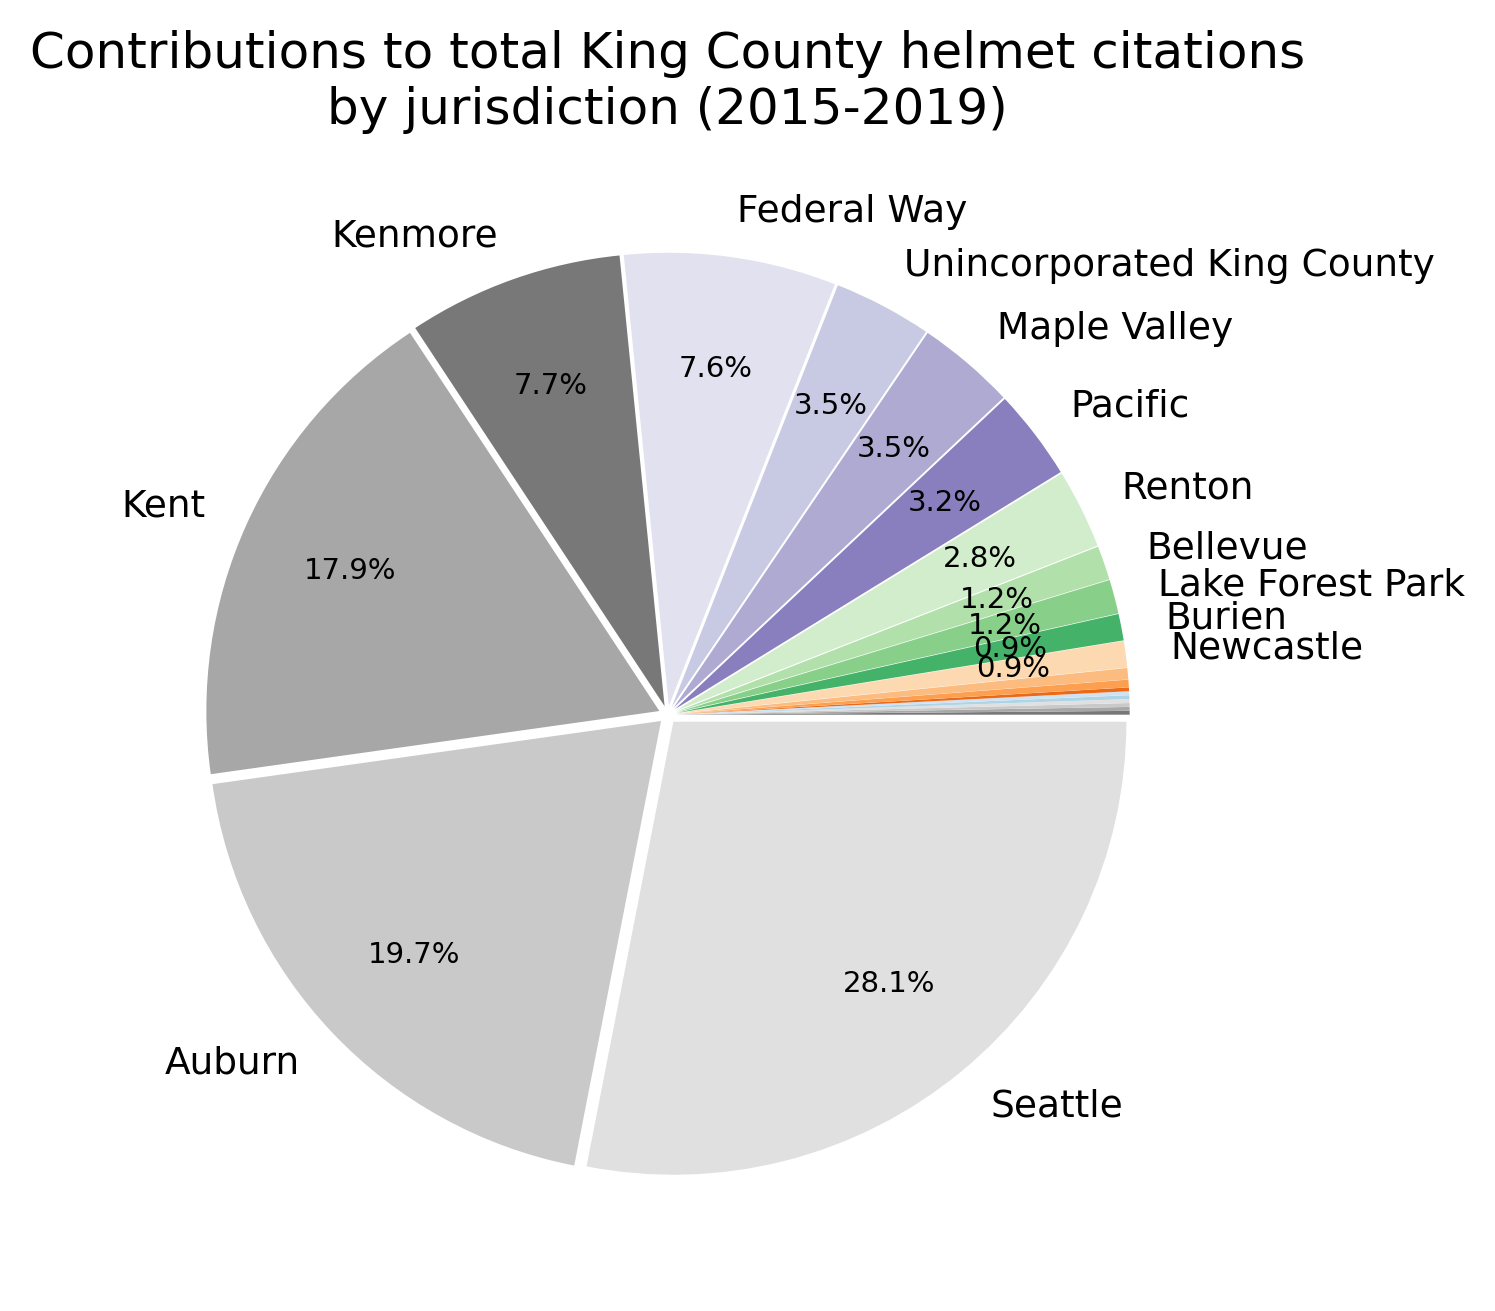

In [715]:
# recent average annual citations by city
city_contributions = cities['Average annual citations (2015-2019 only)'].sort_values().copy()
city_contributions = city_contributions[city_contributions > 0]
labels = [name if 100 * city_contributions[name] / city_contributions.sum() > 0.8 else '' for name in city_contributions.index]
def autopct(percent): return ('%.1f%%' % percent) if percent > 0.8 else ''

plt.figure(figsize=(7,5),facecolor='w')
with plt.style.context({"axes.prop_cycle":plt.cycler('color',roll(plt.cm.tab20c.colors[2:],4,axis=0)**0.8)}):
    wedges, labels, autopct = plt.pie(city_contributions,explode=tile(0.02,len(city_contributions)),
                                      labels=labels,labeldistance=1.10,autopct=autopct,pctdistance=0.75)
for lab in labels: lab.set_fontsize(9)
for pct in autopct: pct.set_fontsize(7)
plt.title('Contributions to total King County helmet citations\nby jurisdiction (2015-2019)');
plt.savefig(current_results_dir + 'king_co_helmet_citations_by_jurisdiction.pdf')

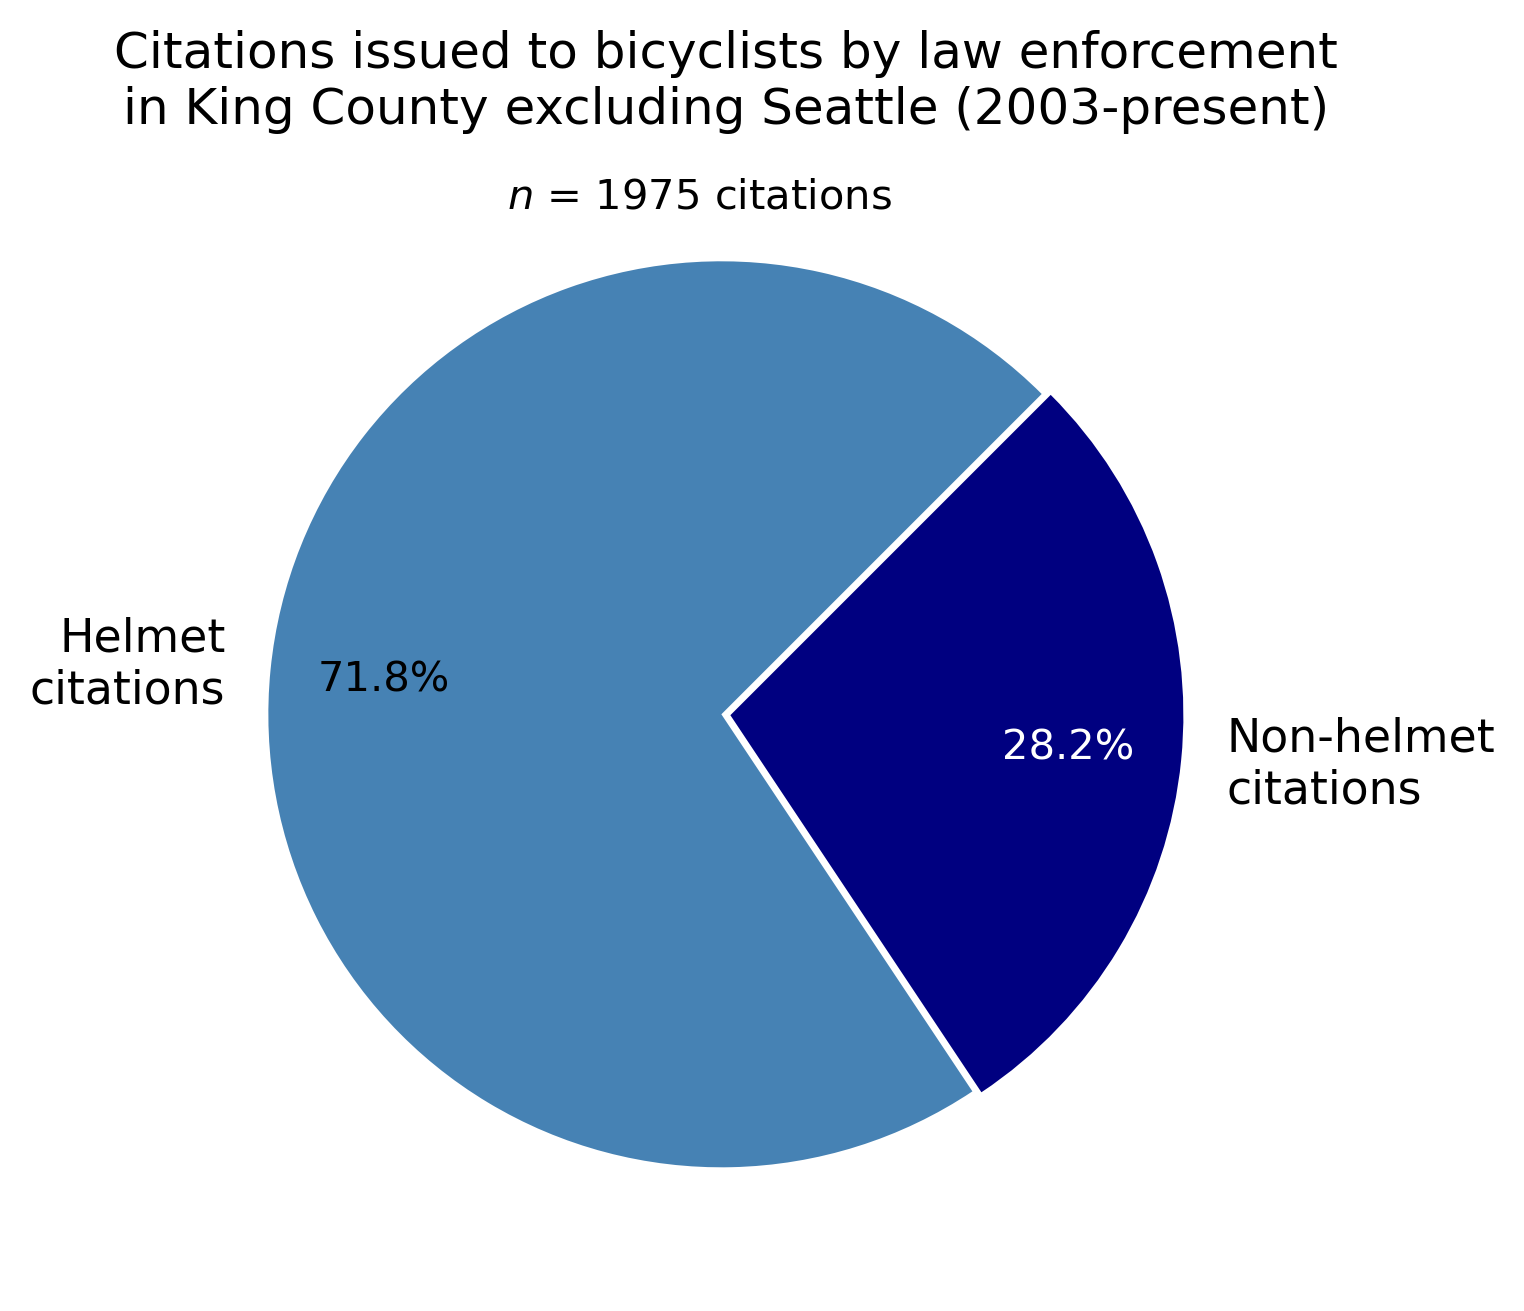

In [705]:
# helmet vs. non-helmet citations in King County outside of Seattle
kc_subset = kc_citations[logical_and(kc_citations['City'] != 'Seattle',kc_citations['Violation Date'].dt.year >= 2003)]
helmet_mask = kc_subset['Law Description'].str.contains('Bicycle Helmet Required')
helmet_percent = 100 * sum(helmet_mask) / len(helmet_mask)
nonhelmet_percent = 100 - helmet_percent
def autopct(percent): return ('%.1f%%' % percent)

plt.figure(figsize=(7,5),facecolor='w')
wedges, labels, autopct = plt.pie([helmet_percent,nonhelmet_percent],explode=tile(0.01,2),startangle=45,
                                  labels=['Helmet\ncitations','Non-helmet\ncitations'],
                                  colors=['steelblue','navy'],
                                  labeldistance=1.10,autopct=autopct,pctdistance=0.75)
autopct[1].set_color('w')
for lab in labels: lab.set_fontsize(11)
for pct in autopct: pct.set_fontsize(10)
plt.title('Citations issued to bicyclists by law enforcement\nin King County excluding Seattle (2003-present)');
plt.text(0.5,0.84,'$n$ = {0} citations'.format(len(helmet_mask)),fontsize=10,
         horizontalalignment='center',transform=plt.gcf().transFigure);
plt.savefig(current_results_dir + 'king_co_bike_citations_type.pdf')

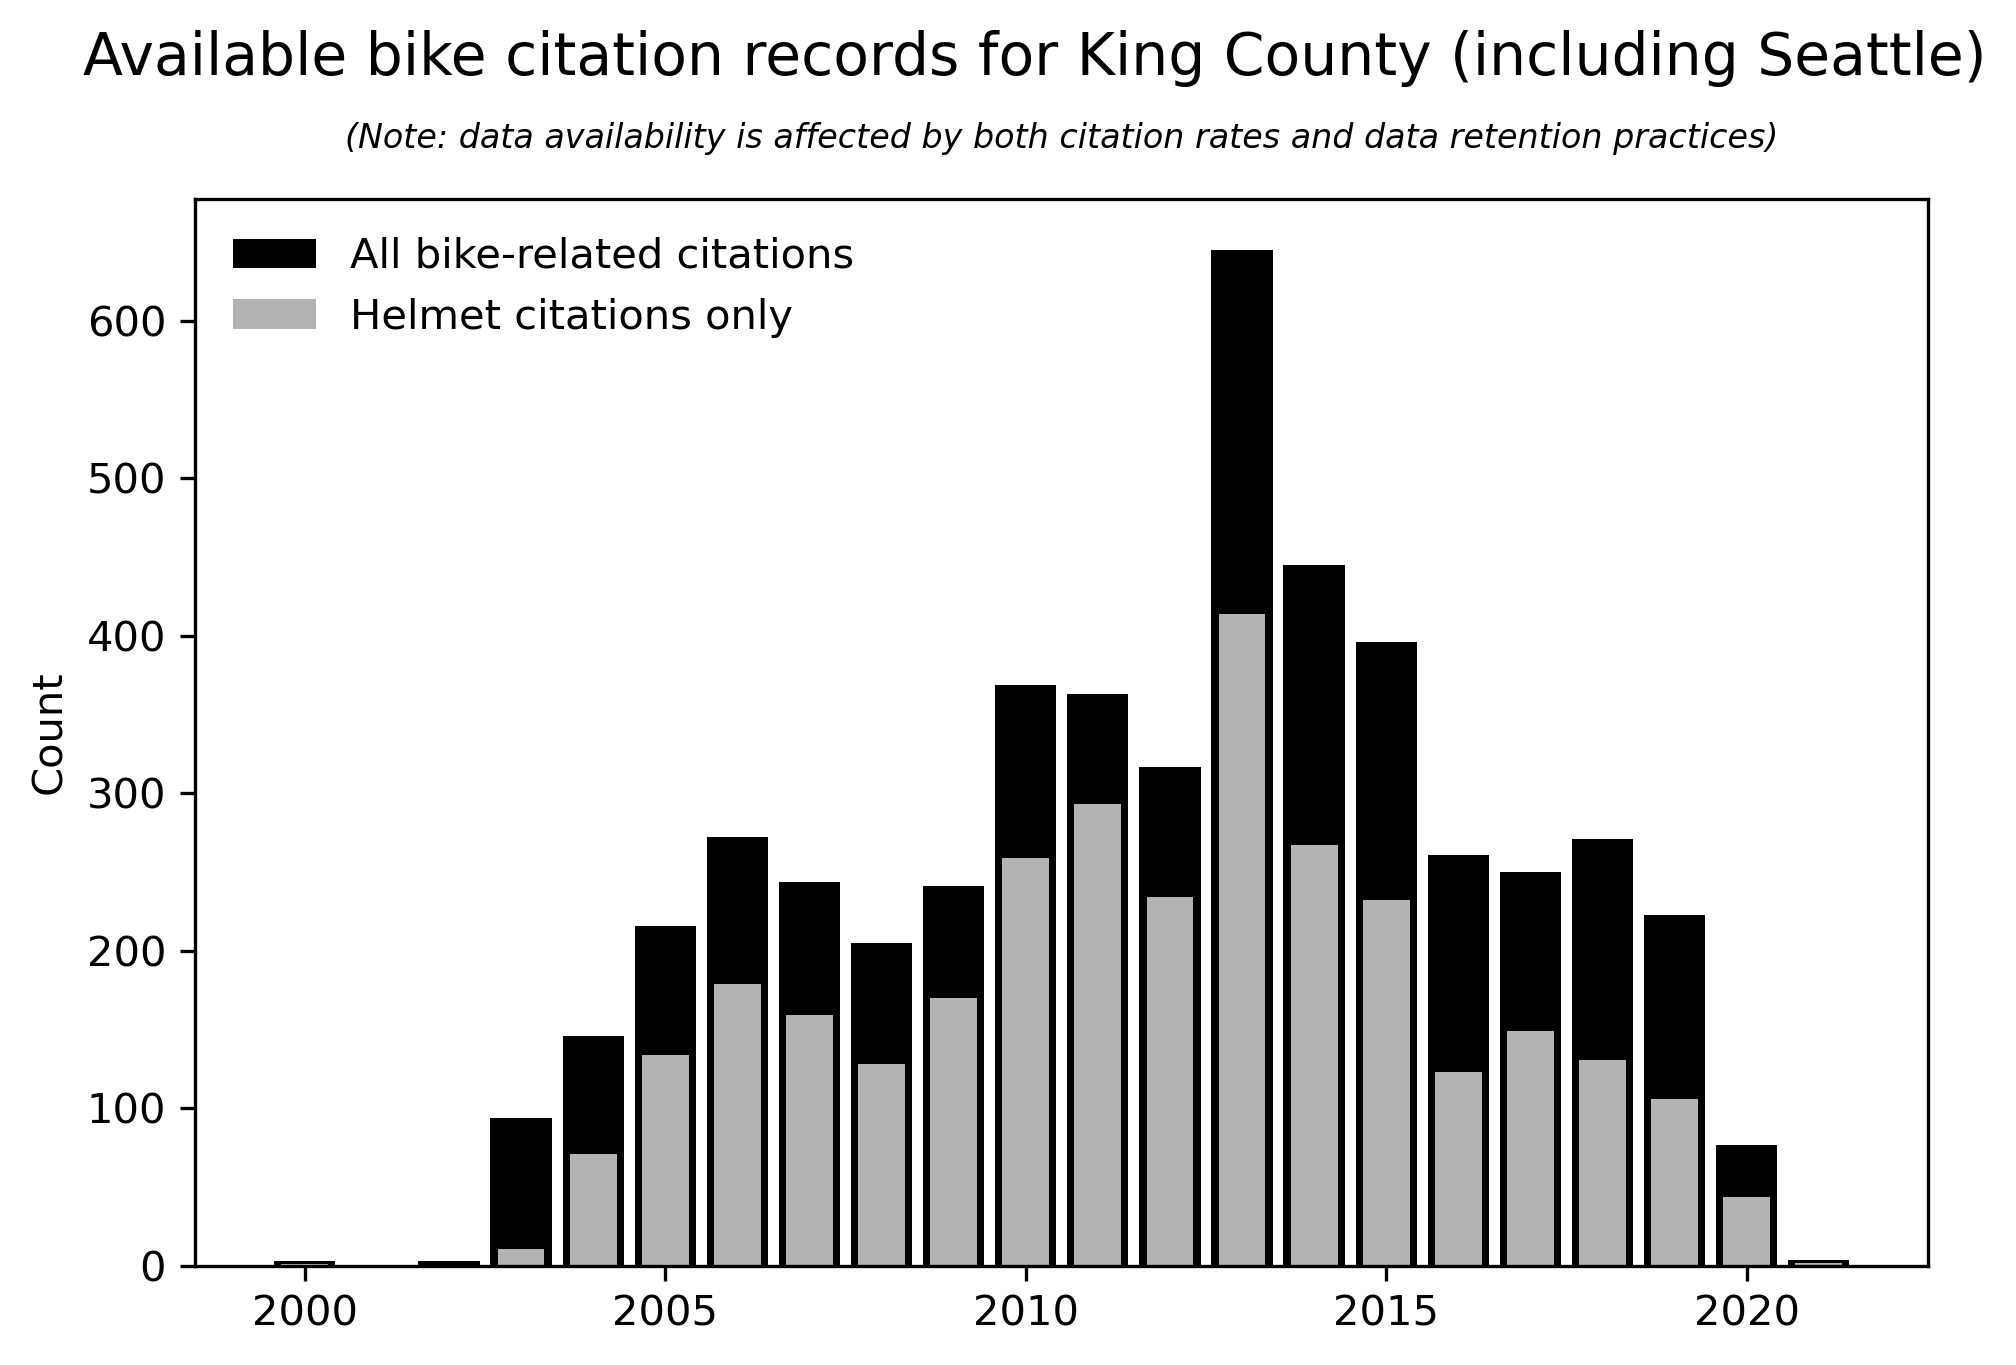

In [717]:
# years of available data
plt.figure(figsize=(7,5),facecolor='w')
plt.hist(kc_citations['Violation Date'].dt.year,bins=arange(1999.5,2022.5),color='k',rwidth=0.85,zorder=1,
         label='All bike-related citations')
plt.hist(kc_citations.loc[kc_citations['Law Description'].str.contains('Bicycle Helmet Required'),'Violation Date'].dt.year,
         bins=arange(1999.5,2022.5),color='0.7',rwidth=0.65,zorder=2,label='Helmet citations only')
plt.legend(loc='upper left',frameon=False)
plt.text(0.5,0.9,'Available bike citation records for King County (including Seattle)',size=14,
         horizontalalignment='center',transform=plt.gcf().transFigure)
plt.title('(Note: data availability is affected by both citation rates and data retention practices)',
          style='italic',size=8,y=1.025)
plt.ylabel('Count');
plt.tight_layout(rect=[0,0.03,1,0.90])
plt.savefig(current_results_dir + 'king_co_bike_citations_by_year.pdf')

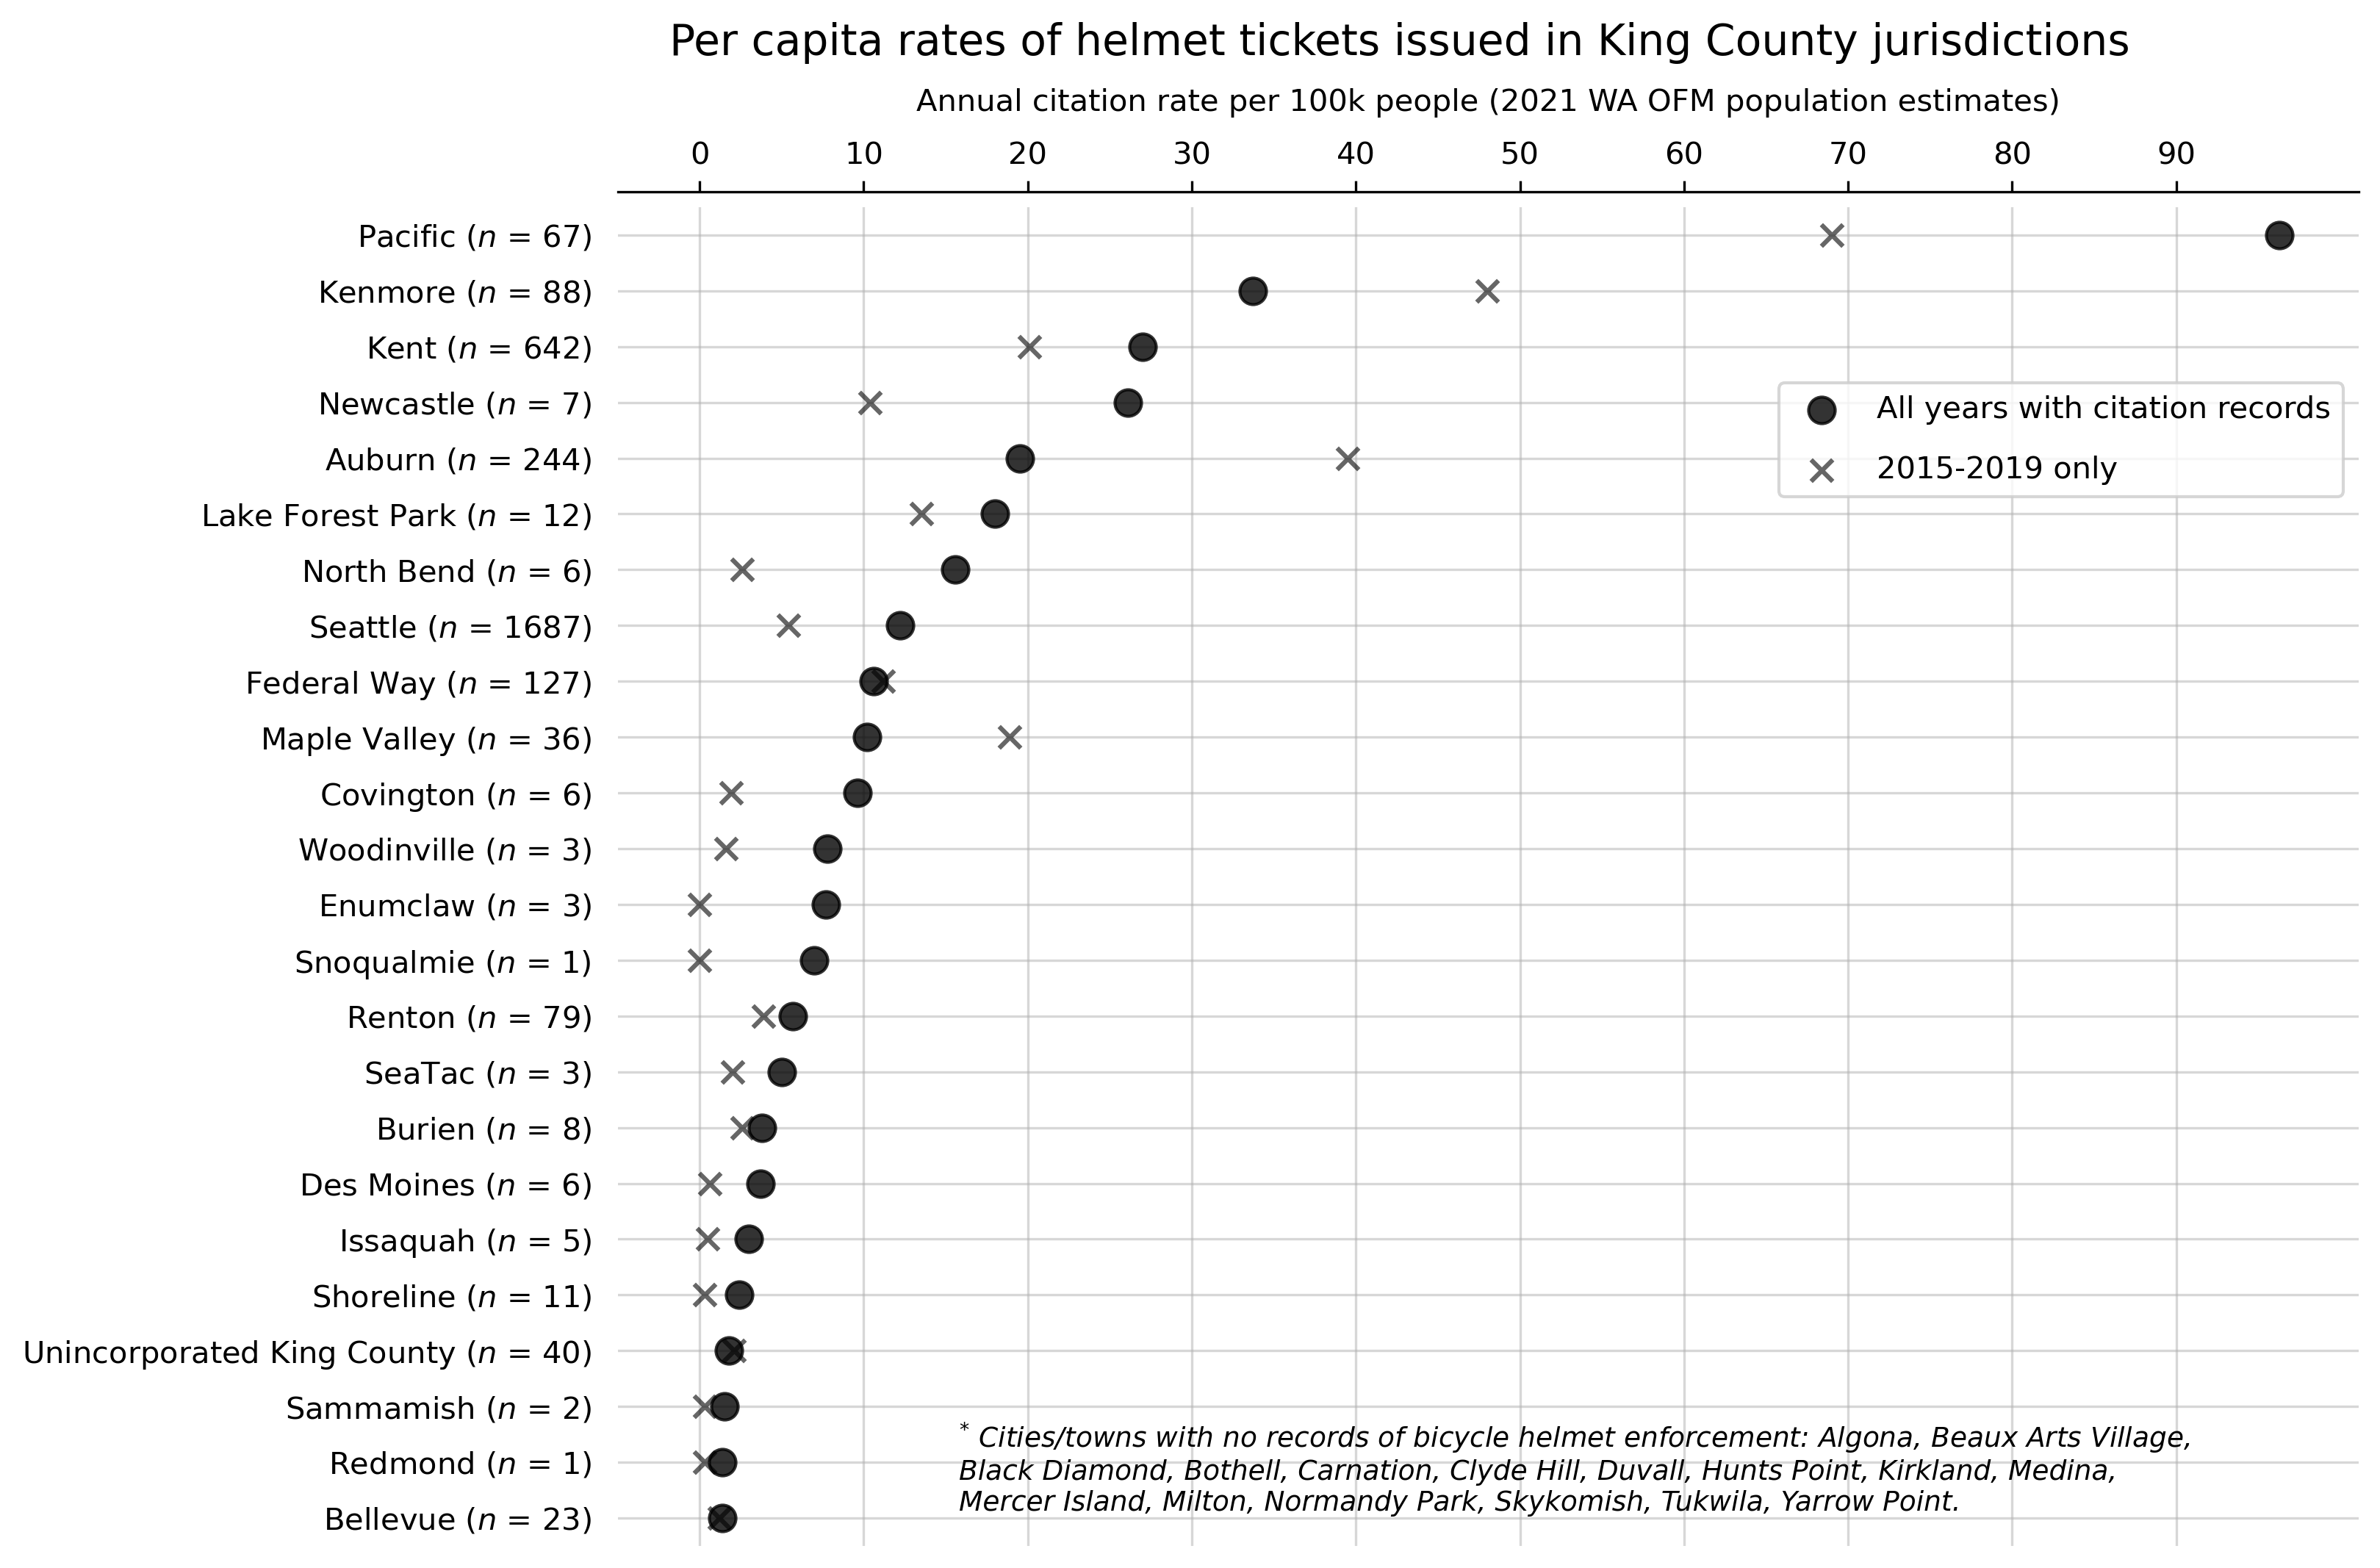

In [802]:
# per-capita helmet citation rates by jurisdiction
cities_subset = cities[['Total helmet citations in records',
                        'Annual citation rate per 100k people (all years)',
                        'Annual citation rate per 100k people (2015-2019 only)']].copy()
cities_without_enforcement = cities_subset[cities_subset['Total helmet citations in records'] == 0].index.values
cities_subset = cities_subset[cities_subset['Total helmet citations in records'] != 0]
cities_subset.sort_values(by='Annual citation rate per 100k people (all years)',inplace=True)

plt.figure(figsize=(11,7.5),facecolor='w')
plt.scatter(cities_subset['Annual citation rate per 100k people (all years)'],range(len(cities_subset)),
            marker='o',s=75,c='k',zorder=3,alpha=0.8,label='All years with citation records')
plt.scatter(cities_subset['Annual citation rate per 100k people (2015-2019 only)'],range(len(cities_subset)),
            marker='x',s=50,c='k',zorder=3,alpha=0.6,label='2015-2019 only')
plt.legend(bbox_to_anchor=(1.0,0.88),loc='upper right',frameon=True,labelspacing=1.0)
plt.yticks(ticks=range(len(cities_subset)),
           labels=[city + ' ($n$ = {0})'.format(cities_subset.loc[city,'Total helmet citations in records']) \
                   for city in cities_subset.index])
plt.xlim([-5,None])
plt.ylim([-0.5,len(cities_subset)-0.5])
plt.grid(alpha=0.5,zorder=1)
plt.gca().spines['left'].set_position(('outward',5))
plt.gca().spines['top'].set_position(('outward',5))
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='y',length=0)
plt.gca().xaxis.set_ticks_position("top")
plt.gca().xaxis.set_label_position("top")
plt.xticks(ticks=arange(0,100,10))
plt.xlabel('Annual citation rate per 100k people (2021 WA OFM population estimates)',labelpad=10)
plt.title('Per capita rates of helmet tickets issued in King County jurisdictions             ',size=14,y=1.10)
cities_without_enforcement[2] = '\n' + cities_without_enforcement[2]
cities_without_enforcement[10] = '\n' + cities_without_enforcement[10]
plt.text(0.4,0.085,'$^{*}$ ' + 'Cities/towns with no records of bicycle helmet enforcement: {0}.'\
         .format(', '.join(cities_without_enforcement).rstrip(',')),
         size=9,transform=plt.gcf().transFigure,style='italic')
plt.tight_layout()
plt.savefig(current_results_dir + 'king_co_helmet_citation_rates_by_jurisdiction.pdf')

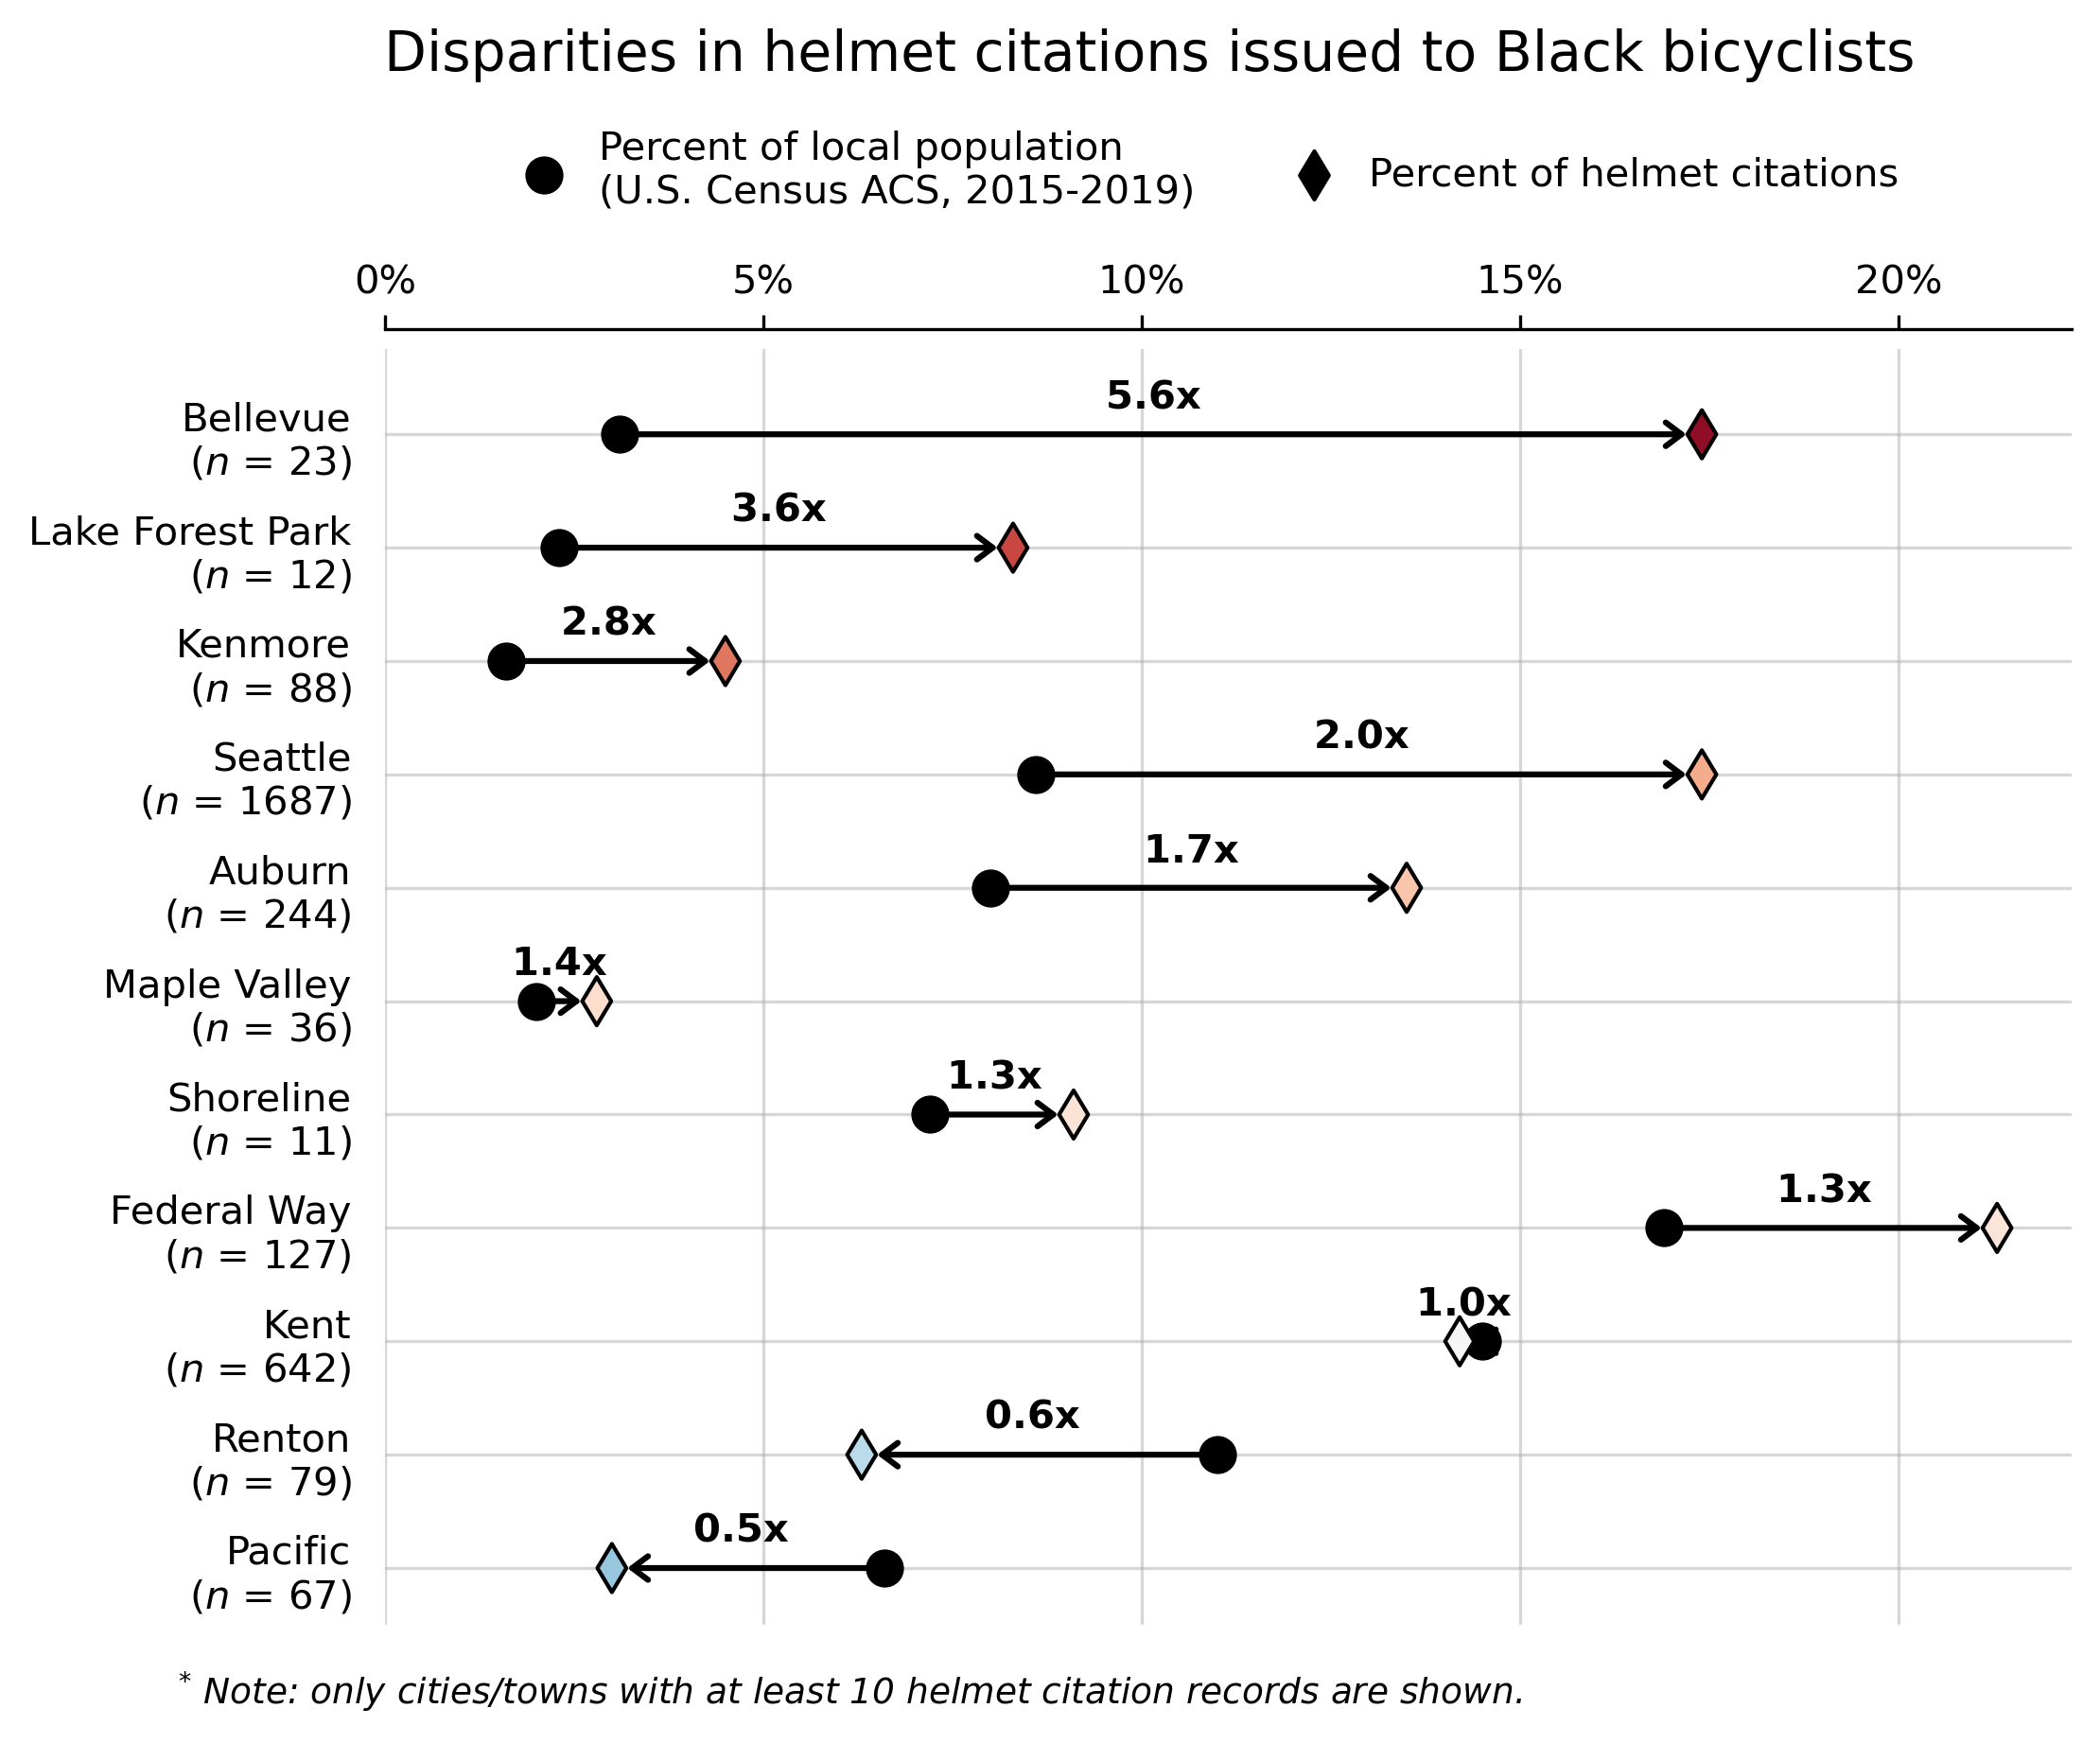

In [779]:
# helmet citation disparities for Black defendants
cities_subset = cities[['Total helmet citations in records',
                        'Citations - White (%)','Census (2015-2019) - White (%)',
                        'Citations - Black (%)','Census (2015-2019) - Black (%)']].copy().drop('Unincorporated King County')
cities_subset = cities_subset[cities_subset['Total helmet citations in records'] != 0]
cities_subset['Disparity in citations issued to Black cyclists'] \
    = (cities_subset['Citations - Black (%)'] / cities_subset['Census (2015-2019) - Black (%)'])
disparities = cities_subset['Disparity in citations issued to Black cyclists']\
    [cities_subset['Total helmet citations in records'] > 10]
disparities.sort_values(inplace=True)

plt.figure(figsize=(7.5,6.5),facecolor='w')
plt.scatter(cities_subset['Census (2015-2019) - Black (%)'][disparities.index],range(len(disparities)),
            marker='o',s=75,c='k',zorder=3,label='Percent of local population\n(U.S. Census ACS, 2015-2019)')
plt.scatter(cities_subset['Citations - Black (%)'][disparities.index],range(len(disparities)),
            marker='d',edgecolors='k',s=75,zorder=3,
            c=disparities,cmap='RdBu_r',norm=mcolors.LogNorm(vmin=1.35e-1,vmax=0.7e1))
plt.scatter(NaN,NaN,marker='d',c='k',edgecolors='k',s=75,label='Percent of helmet citations')
for c_idx, city in enumerate(disparities.index):
    if cities_subset.loc[city,'Census (2015-2019) - Black (%)'] > cities_subset.loc[city,'Citations - Black (%)']:
        d = 0.1
    else:
        d = -0.1
    plt.annotate(text=None,xy=(cities_subset.loc[city,'Census (2015-2019) - Black (%)'],c_idx),
                 xytext=(cities_subset.loc[city,'Citations - Black (%)']+d,c_idx),
                 arrowprops=dict(arrowstyle='<-, head_width=0.3',linewidth=1.5))
    plt.text(0.5*(cities_subset.loc[city,'Census (2015-2019) - Black (%)'] + 
                  cities_subset.loc[city,'Citations - Black (%)']),c_idx + 0.23,
             '{0:.1f}x '.format(disparities.loc[city]),weight='bold',horizontalalignment='center')
plt.legend(bbox_to_anchor=(0.05,1.20),loc='upper left',ncol=2,handletextpad=0.4,frameon=False)
plt.yticks(ticks=range(len(disparities)),
           labels=[city + '\n($n$ = {0})'.format(cities_subset.loc[city,'Total helmet citations in records']) \
                   for city in disparities.index])
plt.xlim([0,None])
plt.ylim([-0.5,len(disparities)-0.25])
plt.grid(alpha=0.5,zorder=1)
plt.gca().spines['left'].set_position(('outward',5))
plt.gca().spines['top'].set_position(('outward',5))
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='y',length=0)
plt.gca().xaxis.set_ticks_position("top")
plt.gca().xaxis.set_label_position("top")
plt.xticks(ticks=arange(0,25,5))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
# plt.colorbar()
plt.title('Disparities in helmet citations issued to Black bicyclists         ',size=14,y=1.2)
plt.text(0.09,0.055,'$^{*}$ Note: only cities/towns with at least 10 helmet citation records are shown.',
         size=9,transform=plt.gcf().transFigure,style='italic');
plt.tight_layout()
plt.savefig(current_results_dir + 'king_co_helmet_citation_disparities.pdf')